# Instalación e Importación de Librerías

In [189]:
! pip install sqlalchemy==1.4.46
! pip install pandasql==0.7.3


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [272]:
import sys
import os
sys.path.append(".")
import pandas as pd
import pandasql as ps
from datetime import timedelta
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
def thousands_formatter_func(x, pos):
    return f'{int(x / 1e3)}K'
thousand_formatter = FuncFormatter(thousands_formatter_func)
def percentage_formatter_func(x, pos):
    return f'{int(x * 100)}%'
percentage_formatter = FuncFormatter(percentage_formatter_func)

# Lectura de archivos

## Lectura Dataset de Bombas

In [191]:
df_bombs = pd.read_csv('data/csv/Dataset_Bombes_2020-23.csv', delimiter=';', encoding='latin-1',  dtype={'T_Diff [s]': 'object'})
df_bombs['dhIni'] = pd.to_datetime(df_bombs['dhIni'], format='%Y-%m-%d %H:%M:%S.%f')
df_bombs['dhFin'] = pd.to_datetime(df_bombs['dhFin'], format='%Y-%m-%d %H:%M:%S.%f')
df_bombs['T_Diff [s]'] = df_bombs['T_Diff [s]'].fillna('0').str.replace('.', '').replace(',', '.').astype(int)
df_bombs['TiempoTeorico [min]'] = df_bombs['TiempoTeorico [min]'].fillna('0').str.replace('.', '').str.replace(',', '.').astype(float)
df_bombs['Orden'] = df_bombs['Orden'].fillna(0).astype(int)
df_bombs['OperIds'] = df_bombs['OperIds'].fillna('')

df_bombs.rename(columns={
    'Orden': 'order',
    'CodMaterial': 'bomb_type',
    'DescMaterial': 'bomb_description',
    'maquina_dsc': 'line',
    'QtyPlan': 'plan_qty',
    'QtyBuenas_Total': 'total_good_qty',
    'QtyMalas_Total': 'total_bad_qty',
    'CantidadBuenas': 'good_qty',
    'CantidadMalas': 'bad_qty',
    'dhIni': 'start_date',
    'dhFin': 'end_date',
    'T_Diff [s]': 'theorical_diff',
    'IncidName': 'incidence_name',
    'Observaciones': 'observations',
    'TiempoTeorico [min]': 'theorical_time',
    'OperariosEnMaq': 'operators_qty',
    'OperIds': 'operators_ids'    
}, inplace=True)

print(df_bombs.shape)
print(df_bombs.dtypes)
df_bombs.head()

(120978, 17)
order                        int32
bomb_type                   object
bomb_description            object
line                        object
plan_qty                   float64
total_good_qty             float64
total_bad_qty              float64
good_qty                   float64
bad_qty                    float64
start_date          datetime64[ns]
end_date            datetime64[ns]
theorical_diff               int32
incidence_name              object
observations                object
theorical_time             float64
operators_qty              float64
operators_ids               object
dtype: object


C:\Users\Enrique Urrutia\AppData\Local\Temp\ipykernel_21408\953803830.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_bombs['T_Diff [s]'] = df_bombs['T_Diff [s]'].fillna('0').str.replace('.', '').replace(',', '.').astype(int)
C:\Users\Enrique Urrutia\AppData\Local\Temp\ipykernel_21408\953803830.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_bombs['TiempoTeorico [min]'] = df_bombs['TiempoTeorico [min]'].fillna('0').str.replace('.', '').str.replace(',', '.').astype(float)


,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids
0,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:20.250,2020-01-02 05:53:50.063,30,Produccion,NaN,85.00,1.0,5025
1,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:50.063,2020-01-02 05:54:08.010,18,Produccion,NaN,85.00,1.0,5025
2,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:54:08.010,2020-01-02 08:49:39.577,10531,Produccion,NaN,85.00,1.0,5025
3,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 08:49:39.577,2020-01-02 08:59:16.247,577,Produccion,NaN,85.00,1.0,5025
4,5165729,01224-0890,B.CENT.20CV 400/690 1450 S/PR,LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2020-01-02 08:59:48.200,2020-01-02 09:02:40.420,172,Produccion,NaN,85.58,1.0,5025


## Lectura Dataset Defectuosas Interna

In [192]:
df_defective = pd.read_csv('data/csv/Defectuositat_Interna_2020-23.csv', delimiter=';', encoding='latin-1')[:-3]
df_defective['Jornada'] = pd.to_datetime(df_defective['Jornada'], format='%d-%m-%y')
print(df_defective.shape)
print(df_defective.dtypes)
df_defective.head()


(1853, 15)
Jornada       datetime64[ns]
Maq.                  object
OF                   float64
Descripció            object
Item                  object
Component             object
Qty                  float64
T.I.                  object
Motiu                 object
Decisió               object
Units FR             float64
Qty. Fab.            float64
Q.F./Dia             float64
FR                    object
FR/Dia                object
dtype: object


,Jornada,Maq.,OF,Descripció,Item,Component,Qty,T.I.,Motiu,Decisió,Units FR,Qty. Fab.,Q.F./Dia,FR,FR/Dia
0,2023-01-04,LINEA 3,5373418.0,BOMBA VERDON ES 075M,73678,73678-0475,NaN,G,DAÑOS O GOLPES,Destruir,NaN,408.0,NaN,NaN,NaN
1,2023-01-04,LINEA 4,5372007.0,B.A.SENA 33M,25461,25461-0300,NaN,R,ROSCADO EJE MOTOR N/OK,Destruir,NaN,192.0,NaN,NaN,NaN
2,2023-01-04,LINEA 4,5372007.0,B.A.SENA 33M,25461,25461-9601F,NaN,G,FUGAS CIERRE MECÁNICO,Recuperable In Situ,NaN,192.0,NaN,NaN,NaN
3,2023-01-03,LÍNEA KIVU,5371822.0,BOMBA KIVU 4HP 400/6,63043-0890,72A4000075,NaN,G,DAÑOS O GOLPES,Destruir,NaN,6.0,NaN,NaN,NaN
4,2023-01-02,LÍNEA 2,5371351.0,BOMBA V.PLUS SILENT,65562,77C2000064,NaN,G,MONTAJE JUNTA N/OK,Recuperable In Situ,NaN,792.0,NaN,NaN,NaN


## Información Relevante de Bombas

In [193]:
df_exp = df_bombs.operators_ids.str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('operators_ids')

In [194]:
print(f"""Resumen información relevante sobre el Dataset de bombas:
--> Cantidad de Órdenes de fabicación: {df_bombs.order.nunique()}
--> Cantidad de distintos materiales: {df_bombs.bomb_type.nunique()}
--> Cantidad de lineas/máquinas: {df_bombs.line.nunique()}
--> Cantidad máxima registrada de operarios en máquinas: {df_bombs.operators_qty.max()}
--> Cantidad de operarios distintos que trabajan en la planta: {df_exp.operators_ids.nunique()}

--> Fecha más antigua de registros: {df_bombs.start_date.min()}
--> Fecha más nueva de registros: {df_bombs.end_date.max()}    
""")

Resumen información relevante sobre el Dataset de bombas:
--> Cantidad de Órdenes de fabicación: 5555
--> Cantidad de distintos materiales: 724
--> Cantidad de lineas/máquinas: 10
--> Cantidad máxima registrada de operarios en máquinas: 8.0
--> Cantidad de operarios distintos que trabajan en la planta: 117

--> Fecha más antigua de registros: 2020-01-02 05:49:27.273000
--> Fecha más nueva de registros: 2023-02-13 13:30:36.823000    



### Revisión de casos Diff cero

In [195]:
print(df_bombs[df_bombs.theorical_diff < 0].order.unique())
df_bombs[df_bombs.theorical_diff < 0].order.nunique()

[5263472 5273225 5275960 5253657 5268390 5288629 5261566 5267248 5257965
 5256172 5265480 5265141 5255357 5274189 5273874 5274188 5281115 5281112
 5287266 5271238 5272862 5280384 5279750 5276295 5278425 5266757 5278420
 5279741 5281111 5282399 5278101 5286927 5286654 5292715 5277735 5282392
 5282397 5292409 5292408 5289828 5278864 5280048 5295482 5280388 5295485
 5293107 5292717 5295268 5279198 5297069 5300944 5288215 5297071 5299075
 5293349 5298783 5302107 5298199 5295267 5305865 5288214 5293108 5304372
 5298785 5293109 5298791 5305922 5298787 5305904 5307933 5310395 5303175
 5306488 5288639 5297584 5295741 5262185 5263883 5281110 5327074 5265473
 5276292 5288137 5282079 5296682 5259363 5313918 5313939 5327336 5327338
 5333201]


91

In [196]:
df_bombs[df_bombs.order == 5263472]

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids
3234,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2021-07-01 09:34:25.470,2021-07-01 09:35:51.207,86,Produccion,NaN,80.0,1.0,5004
3235,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2021-07-01 09:35:51.207,2021-07-01 09:36:15.723,24,Produccion,NaN,80.0,1.0,5004
3236,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2021-07-01 09:36:15.723,2021-07-01 09:14:58.547,-1277,Produccion,NaN,80.0,1.0,5004
3237,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2021-07-01 10:36:50.950,2021-07-01 12:32:11.630,6921,Produccion,NaN,80.0,1.0,5004
3238,5263472,01205-0930,"B.CENT.12,5CV 400/690 3000 R.B",LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2021-07-01 12:32:11.630,2021-07-01 12:32:22.540,11,Produccion,NaN,80.0,1.0,5004


In [197]:
df_bombs[(df_bombs.theorical_diff < 0) & (df_bombs.good_qty != 0)].order.nunique()

82

Conclusión: eliminar la OF que contengan registros?

## Limpieza

In [295]:
negative_of = df_bombs[df_bombs.time_diff_minutes_calculated < 0].order.unique()
negative_of


array([5263472, 5273225, 5275960, 5253657, 5268390, 5288629, 5261566,
       5267248, 5257965, 5256172, 5265480, 5265141, 5255357, 5274189,
       5273874, 5274188, 5281115, 5281112, 5287266, 5271238, 5272862,
       5280384, 5279750, 5276295, 5278425, 5266757, 5278420, 5279741,
       5281111, 5282399, 5278101, 5286927, 5286654, 5292715, 5277735,
       5282392, 5282397, 5292409, 5292408, 5289828, 5278864, 5280048,
       5295482, 5280388, 5295485, 5293107, 5292717, 5295268, 5279198,
       5297069, 5300944, 5288215, 5297071, 5299075, 5293349, 5298783,
       5302107, 5298199, 5295267, 5305865, 5288214, 5293108, 5304372,
       5298785, 5293109, 5298791, 5305922, 5298787, 5305904, 5307933,
       5310395, 5303175, 5306488, 5288639, 5297584, 5295741, 5262185,
       5263883, 5281110, 5327074, 5265473, 5276292, 5288137, 5282079,
       5296682, 5259363, 5313918, 5313939, 5327336, 5327338, 5333201])

Eliminación de OF con tiempos negativos (confirmar con cliente)

In [298]:
df_bombs = df_bombs[~df_bombs.order.isin(negative_of)]

## Generación cantidad teórica calculada por registro

Creamos nuestra propias columnas calculadas: <br>
* Cantidad de trabajadores por registro según los ids asociados.
* Diferencia en segundos de tiempo de inicio con tiempo de fin de registro
* Diferencia en minutos de tiempo de inicio con tiempo de fin de registro
* Total de *minutos-hombre* trabajados en el registro ${duración de registo en minutos \times cantidad de operarios en el registro}$

In [299]:
df_bombs['operators_qty_calculated'] = df_bombs.operators_ids.apply(lambda x: len(list(filter(lambda s: s != "", x.split(',')))))
df_bombs['time_diff_seconds_calculated'] = (df_bombs['end_date'] - df_bombs['start_date']) / pd.Timedelta(seconds=1)
df_bombs['time_diff_minutes_calculated'] = (df_bombs['end_date'] - df_bombs['start_date']) / pd.Timedelta(minutes=1)

df_bombs['total_operators_minutes'] = df_bombs['operators_qty_calculated'] * df_bombs['time_diff_minutes_calculated']

df_bombs

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids,operators_qty_calculated,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes
0,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:20.250,2020-01-02 05:53:50.063,30,Produccion,NaN,85.00,1.0,5025,1,29.813,0.496883,0.496883
1,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:50.063,2020-01-02 05:54:08.010,18,Produccion,NaN,85.00,1.0,5025,1,17.947,0.299117,0.299117
2,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:54:08.010,2020-01-02 08:49:39.577,10531,Produccion,NaN,85.00,1.0,5025,1,10531.567,175.526117,175.526117
3,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 08:49:39.577,2020-01-02 08:59:16.247,577,Produccion,NaN,85.00,1.0,5025,1,576.670,9.611167,9.611167
4,5165729,01224-0890,B.CENT.20CV 400/690 1450 S/PR,LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2020-01-02 08:59:48.200,2020-01-02 09:02:40.420,172,Produccion,NaN,85.58,1.0,5025,1,172.220,2.870333,2.870333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120973,5379566,SE2N050M-HS,"B.NEWSE R.I.0,5 CV II R.5425",LINEA 8 IML,30.0,30.0,0.0,1.0,0.0,2023-02-13 07:30:12.033,2023-02-13 07:33:12.597,180,Produccion,NaN,11.00,4.0,"8250,9109,9279,9351,",4,180.564,3.009400,12.037600
120974,5379566,SE2N050M-HS,"B.NEWSE R.I.0,5 CV II R.5425",LINEA 8 IML,30.0,30.0,0.0,1.0,0.0,2023-02-13 07:33:12.597,2023-02-13 07:34:44.927,92,Produccion,NaN,11.00,4.0,"8250,9109,9279,9351,",4,92.330,1.538833,6.155333
120975,5379566,SE2N050M-HS,"B.NEWSE R.I.0,5 CV II R.5425",LINEA 8 IML,30.0,30.0,0.0,1.0,0.0,2023-02-13 07:34:44.927,2023-02-13 07:36:24.893,100,Produccion,NaN,11.00,4.0,"8250,9109,9279,9351,",4,99.966,1.666100,6.664400
120976,5379566,SE2N050M-HS,"B.NEWSE R.I.0,5 CV II R.5425",LINEA 8 IML,30.0,30.0,0.0,0.0,0.0,2023-02-13 07:36:24.893,2023-02-13 07:38:02.443,98,Produccion,NaN,11.00,4.0,"8250,9109,9279,9351,",4,97.550,1.625833,6.503333


In [382]:
df_of[(df_of['end_date'] - df_of['start_date']) / pd.Timedelta(minutes=60) > 120]

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
0,274185,HPS050M,LÍNEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"[8164, 8615, 9105, 8177, 918, 8830, 8860, 287,...",10,11,44.226687,44.0,0.000000,0.000000
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"[8866, 8860, 9120, 5020, 8822]",4,5,0.353680,0.0,0.000000,NaN
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"[9142, 5033, 9436]",8,3,34.185148,34.0,0.000000,0.000000
8,5159134,65567,LÍNEA 2,270.0,270.0,0.0,270.0,0.0,2020-01-02 12:28:00.403,2020-01-08 06:20:32.553,36783,6.40,36783.083,613.051383,2446.176833,"[8615, 918, 8230, 504]",25,4,382.215130,382.0,0.706408,0.706806
15,5162031,8005,LINEA 6,90.0,90.0,0.0,90.0,0.0,2020-01-03 12:18:23.493,2020-01-09 10:04:07.950,49428,21.54,49427.394,823.789900,2393.615867,"[287, 7028, 8945]",28,3,111.124228,111.0,0.809904,0.810811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5321,5374958,25463,LINEA 4,510.0,510.0,0.0,510.0,0.0,2023-01-13 11:34:28.843,2023-01-19 08:44:06.417,110186,7.10,110187.119,1836.451983,3803.301117,"[9142, 8833, 8164, 9279, 9351]",52,5,535.676214,536.0,0.952068,0.951493
5322,5374960,25463,LINEA 4,270.0,270.0,0.0,271.0,0.0,2023-02-03 05:34:35.807,2023-02-08 11:48:54.497,112247,7.10,112247.123,1870.785383,1870.785383,[8164],23,1,263.490899,263.0,1.028499,1.030418
5324,5374962,25465,LINEA 4,540.0,540.0,0.0,541.0,0.0,2023-01-19 09:12:15.957,2023-01-26 09:55:57.447,153218,7.10,153217.390,2553.623167,3808.792600,"[8833, 8164, 8615, 918, 654]",60,5,536.449662,536.0,1.008482,1.009328
5336,5375555,8003,LINEA 6,90.0,90.0,0.0,90.0,0.0,2023-01-25 13:32:57.343,2023-01-31 11:54:36.673,110822,21.54,110822.267,1847.037783,1847.037783,[9142],26,1,85.749201,86.0,1.049572,1.046512


In [394]:
oper_list = []
for  x in df_of[df_of.operators_distinct_qty == 1].operators_distinct_ids:
    operador = x[0]
    if operador not in oper_list:
        oper_list.append(operador)
        
oper_list
len(oper_list)

25

## Agrupación por Orden de fabricación

In [301]:
df_bombs[df_bombs.order == 5169247]

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids,operators_qty_calculated,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes
8,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:04:45.133,2020-01-03 07:07:13.683,148,Produccion,NaN,80.0,1.0,5025,1,148.550,2.475833,2.475833
9,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:07:13.683,2020-01-03 07:07:47.823,34,Produccion,NaN,80.0,1.0,5025,1,34.140,0.569000,0.569000
10,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:07:47.823,2020-01-03 07:08:02.013,15,Produccion,NaN,80.0,1.0,5025,1,14.190,0.236500,0.236500
11,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:08:02.013,2020-01-03 07:08:21.290,19,Produccion,NaN,80.0,2.0,"5004,5025,",2,19.277,0.321283,0.642567
12,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,4.0,0.0,2020-01-03 07:08:21.290,2020-01-03 10:14:38.720,11177,Produccion,NaN,80.0,2.0,"5004,5025,",2,11177.430,186.290500,372.581000
13,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,2.0,0.0,2020-01-03 10:14:38.720,2020-01-03 11:28:13.407,4415,Produccion,NaN,80.0,2.0,"5004,5025,",2,4414.687,73.578117,147.156233
14,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,3.0,0.0,2020-01-03 11:28:13.407,2020-01-03 13:36:05.923,7672,Produccion,NaN,80.0,2.0,"5004,5025,",2,7672.516,127.875267,255.750533
15,5169247,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 13:36:05.923,2020-01-03 13:36:17.010,12,Produccion,NaN,80.0,2.0,"5004,5025,",2,11.087,0.184783,0.369567


In [302]:
df_bombs_grouped = df_bombs.groupby(
        ['order', 'bomb_type', 'line']
    ).agg(
        plan_qty=('plan_qty', 'max'),
        total_good_qty=('total_good_qty', 'max'),
        total_bad_qty=('total_bad_qty', 'max'),
        good_qty=('good_qty', 'sum'),
        bad_qty=('bad_qty', 'sum'),
        start_date=('start_date', 'min'),
        end_date=('end_date', 'max'),
        theorical_diff=('theorical_diff', 'sum'),
        theorical_time=('theorical_time', 'max'),
        time_diff_seconds_calculated=('time_diff_seconds_calculated', 'sum'),
        time_diff_minutes_calculated=('time_diff_minutes_calculated', 'sum'),
        total_operators_minutes=('total_operators_minutes', 'sum'),
        operators_distinct_ids=('operators_ids', lambda x: list(set([i for s in x if isinstance(s, str) for i in s.split(',') if i]))),
        registers_qty=('start_date', 'count'),
        
    ).reset_index()
df_bombs_grouped['operators_distinct_qty'] = df_bombs_grouped.operators_distinct_ids.apply(lambda x: len(x))
df_bombs_grouped['theorical_qty'] = df_bombs_grouped.total_operators_minutes/df_bombs_grouped.theorical_time
df_bombs_grouped['theorical_qty_round'] = df_bombs_grouped.theorical_qty.round(0)
df_bombs_grouped['performance'] = df_bombs_grouped.good_qty/df_bombs_grouped.theorical_qty
df_bombs_grouped['performance_round'] = df_bombs_grouped.good_qty/df_bombs_grouped.theorical_qty_round
df_bombs_grouped

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
0,274185,HPS050M,LÍNEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,13189,13.35,13189.211,219.820183,590.426267,"[8164, 8615, 9105, 8177, 918, 8830, 8860, 287,...",10,11,44.226687,44.0,0.000000,0.000000
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120,8.80,118.318,1.971967,3.112383,"[8866, 8860, 9120, 5020, 8822]",4,5,0.353680,0.0,0.000000,NaN
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,32671,17.40,32671.480,544.524667,594.821567,"[9142, 5033, 9436]",8,3,34.185148,34.0,0.000000,0.000000
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,1391,8.21,1390.997,23.183283,46.366567,"[5036, 5015]",2,2,5.647572,6.0,1.416538,1.333333
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,12623,85.58,12622.856,210.380933,210.380933,[5025],8,1,2.458296,2.0,0.813572,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,5382620,M00874TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:48:58.883,2023-02-02 16:49:22.223,24,8.41,23.340,0.389000,0.389000,[1007],3,1,0.046254,0.0,21.619537,inf
5462,5382621,M00875TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:47:14.330,2023-02-02 16:48:20.677,66,8.41,66.347,1.105783,1.105783,[1007],3,1,0.131484,0.0,7.605468,inf
5463,5382622,M00876TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:49:43.490,2023-02-02 16:50:07.023,24,8.41,23.533,0.392217,0.392217,[1007],3,1,0.046637,0.0,21.442230,inf
5464,5382623,M00877TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:51:05.457,2023-02-02 16:51:35.050,30,8.41,29.593,0.493217,0.493217,[1007],3,1,0.058646,0.0,17.051330,inf


In [303]:
df_of = df_bombs_grouped.copy()

Más información relevante:

In [304]:
print(f'''
    | Cantidad total órdenes de fabricación: {df_of.shape[0]}
    | Cantidad de órdenes de fabricación con diferencia en cantidad buenas reportadas versus la suma de sus registros: {df_of[df_of.total_good_qty != df_of.good_qty].shape[0]}
        -> Casos CantidadBuenas > QtyBuenas_total : {df_of[df_of.total_good_qty < df_of.good_qty].shape[0]}  
        -> Casos CantidadBuenas < QtyBuenas_total : {df_of[df_of.total_good_qty > df_of.good_qty].shape[0]} 
    
    | Cantidad máxima de operadores trabajando en una misma OF: {df_of.operators_distinct_qty.max()}
    
    | Cantidad de órdenes con Qtyplan distintos a cantidad teórica calculada: {df_of[df_of.plan_qty != df_of.theorical_qty_round].shape[0]}
    
    | Duración máxima (minutos) de un registro: {df_bombs.time_diff_minutes_calculated.max()}
''')


    | Cantidad total órdenes de fabricación: 5466
    | Cantidad de órdenes de fabricación con diferencia en cantidad buenas reportadas versus la suma de sus registros: 325
        -> Casos CantidadBuenas > QtyBuenas_total : 45  
        -> Casos CantidadBuenas < QtyBuenas_total : 280 
    
    | Cantidad máxima de operadores trabajando en una misma OF: 12
    
    | Cantidad de órdenes con Qtyplan distintos a cantidad teórica calculada: 4987
    
    | Duración máxima (minutos) de un registro: 937.5479



Revisión de cantidad de OF operadas por línea:

In [305]:
df_of.groupby('line').size().reset_index(name='count').sort_values(by='count', ascending=False)

,line,count
6,LÍNEA 2,1366
4,LINEA 8 IML,998
0,LINEA 3,686
1,LINEA 4,671
2,LINEA 6,581
5,LÍNEA 1,532
7,LÍNEA KIVU,301
3,LINEA 7,181
8,PREFILTRO L-1,87
9,PREFILTRO L-6,63


Revisión de cantidad de tipos de bombas operadas por máquina:

In [306]:
df_bombs.bomb_type.nunique()

724

In [307]:
df_of.groupby(['line', 'bomb_type']).size().reset_index().groupby(['line']).size().reset_index(name='count').sort_values(by='count', ascending=False)

,line,count
4,LINEA 8 IML,335
0,LINEA 3,131
6,LÍNEA 2,82
1,LINEA 4,59
5,LÍNEA 1,55
2,LINEA 6,42
7,LÍNEA KIVU,32
3,LINEA 7,24
8,PREFILTRO L-1,10
9,PREFILTRO L-6,4


Revisión de líneas por bomba:

In [308]:
df_grouped = df_of.groupby(['line', 'bomb_type']).size().reset_index().groupby(['bomb_type']).size().reset_index(name='lines_count').sort_values(by='lines_count', ascending=False)
print(df_grouped[df_grouped.lines_count >= 2].shape[0])
df_grouped[df_grouped.lines_count >= 2]

49


,bomb_type,lines_count
505,PT001,3
247,65569H,2
235,65566,2
510,SA033MIML000,2
239,65566H,2
240,65566ME,2
241,65567,2
243,65567H,2
244,65567ME,2
245,65569,2


Revisión de tipos de bomba por orden de fabricación

In [309]:
df_grouped = df_of.groupby(['order', 'bomb_type']).size().reset_index().groupby(['order']).size().reset_index(name='count').sort_values(by='count', ascending=False)
df_grouped[df_grouped['count'] > 1]

,order,count


>Nota: órdenes de fabricación hace alusión a un único tipo de bomba

# EDA

## Exploración de Dataset de bombas

### Exploración de valores por columnas

In [310]:
df_bombs.head()

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids,operators_qty_calculated,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes
0,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:20.250,2020-01-02 05:53:50.063,30,Produccion,NaN,85.00,1.0,5025,1,29.813,0.496883,0.496883
1,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:50.063,2020-01-02 05:54:08.010,18,Produccion,NaN,85.00,1.0,5025,1,17.947,0.299117,0.299117
2,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:54:08.010,2020-01-02 08:49:39.577,10531,Produccion,NaN,85.00,1.0,5025,1,10531.567,175.526117,175.526117
3,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 08:49:39.577,2020-01-02 08:59:16.247,577,Produccion,NaN,85.00,1.0,5025,1,576.670,9.611167,9.611167
4,5165729,01224-0890,B.CENT.20CV 400/690 1450 S/PR,LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2020-01-02 08:59:48.200,2020-01-02 09:02:40.420,172,Produccion,NaN,85.58,1.0,5025,1,172.220,2.870333,2.870333


Revisión de cantidad de valores distintos por columna

In [311]:
results = []
for col in df_bombs.columns:
    results.append([col, len(df_bombs[col].unique())])
pd.DataFrame(results, columns=['Column', 'Distinct Values'])

,Column,Distinct Values
0,order,5464
1,bomb_type,725
2,bomb_description,745
3,line,11
4,plan_qty,257
5,total_good_qty,319
6,total_bad_qty,2
7,good_qty,152
8,bad_qty,2
9,start_date,117589


Revisión de tipos de incidencias registrados:

In [312]:
df_bombs.groupby(['incidence_name']).size().reset_index(name='count')

,incidence_name,count
0,Falta de Material,289
1,Preparacion,59
2,Problema Mantenimiento,3305
3,Produccion,114197


> Nota: existen registros que tiene incidencia nula. Por lo observado esto se debe a que la observación de ciertos registros abarca más de una celda en el excel. A validar con el cliente qué hacer con estos casos

### Exploración de desempeño general por máquina

In [317]:
df_bombs.groupby(['line']).agg(good_qty=('good_qty', 'sum'), bad_qty=('bad_qty', 'sum'))


,good_qty,bad_qty
line,,
LINEA 3,67877.0,0.0
LINEA 4,110861.0,0.0
LINEA 6,24104.0,0.0
LINEA 7,43430.0,0.0
LINEA 8 IML,46218.0,0.0
LÍNEA 1,3918.0,0.0
LÍNEA 2,255442.0,0.0
LÍNEA KIVU,1862.0,0.0
PREFILTRO L-1,1138.0,0.0


In [318]:
df_bombs_grouped = df_of.groupby(['line']).agg(theorical_qty=('theorical_qty', 'sum'), theorical_qty_round=('theorical_qty_round', 'sum'), good_qty=('good_qty', 'sum'))
df_bombs_grouped['success_percentage'] = (df_bombs_grouped.good_qty / df_bombs_grouped.theorical_qty *100).round(2) 
df_bombs_grouped['success_percentage_round'] = (df_bombs_grouped.good_qty / df_bombs_grouped.theorical_qty_round *100).round(2)
df_bombs_grouped

,theorical_qty,theorical_qty_round,good_qty,success_percentage,success_percentage_round
line,,,,,
LINEA 3,84608.989077,84630.0,67877.0,80.22,80.20
LINEA 4,117147.735803,117143.0,110861.0,94.63,94.64
LINEA 6,25467.941915,25471.0,24104.0,94.64,94.63
LINEA 7,49048.488617,49045.0,43430.0,88.55,88.55
LINEA 8 IML,67466.196526,67476.0,46218.0,68.51,68.50
LÍNEA 1,4269.411236,4260.0,3918.0,91.77,91.97
LÍNEA 2,280375.853418,280373.0,255442.0,91.11,91.11
LÍNEA KIVU,2274.718984,2282.0,1862.0,81.86,81.60
PREFILTRO L-1,1654.486596,1658.0,1138.0,68.78,68.64


### Gráficas de interés


#### ¿Cuál es el rango de fechas en el dataset? ¿Existen periodos de inactividad notables en la producción?

In [319]:
def plot_daily_production(df, title):
    data_daily = df.resample('D', on='start_date').sum()
    plt.figure(figsize=(10, 5))
    plt.plot(data_daily.index, data_daily['good_qty'])
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de producción')
    plt.title(title)
    plt.show()
    

>Gráfico 1: Series temporales de producción a lo largo del tiempo (por día)

C:\Users\Enrique Urrutia\AppData\Local\Temp\ipykernel_21408\2656114292.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_daily = df.resample('D', on='start_date').sum()


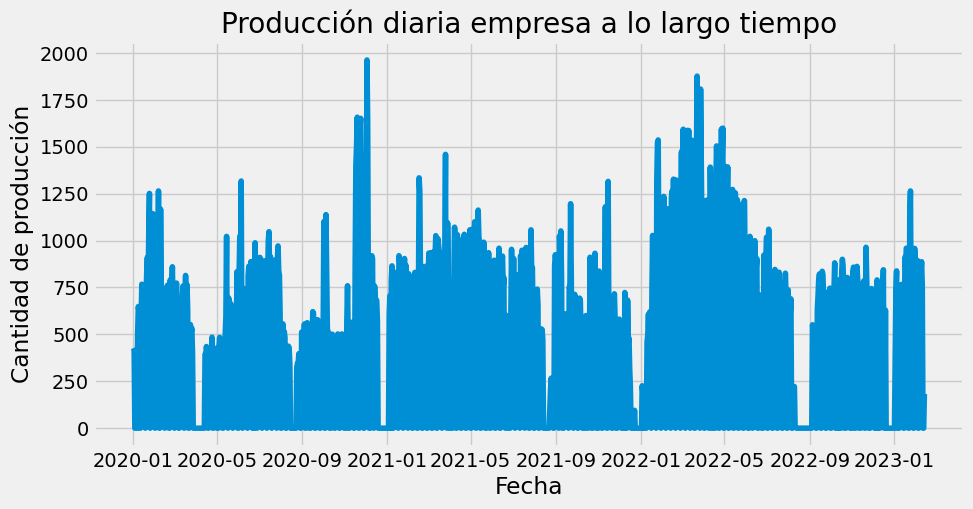

In [320]:
plot_daily_production(df_bombs, 'Producción diaria empresa a lo largo tiempo')

>Gráfico 2: Series temporales de producción a lo largo del tiempo (por día) para el año 2020

C:\Users\Enrique Urrutia\AppData\Local\Temp\ipykernel_21408\2656114292.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_daily = df.resample('D', on='start_date').sum()


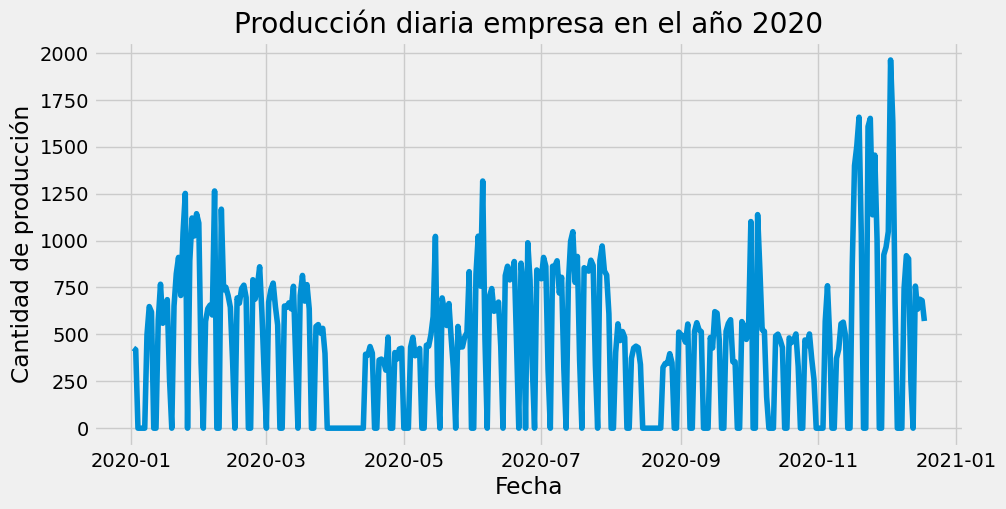

In [321]:
year = 2020
plot_daily_production(df_bombs[df_bombs.start_date.dt.year == year], f'Producción diaria empresa en el año {year}')

>Gráfico 3: Comparación producción mensual por año

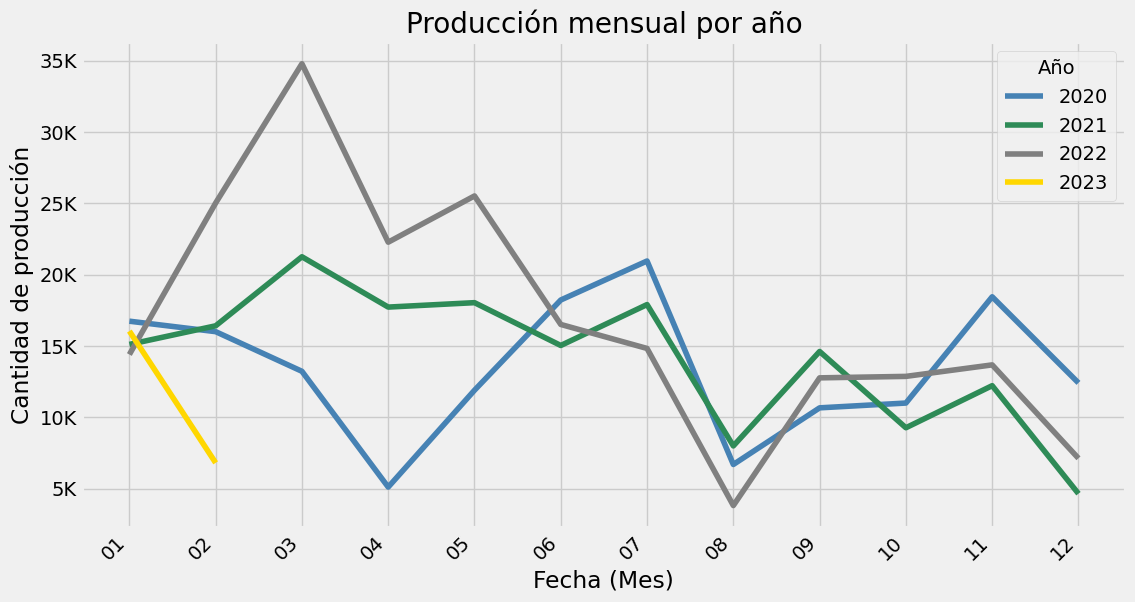

In [322]:
data = df_bombs.copy()
# Crear una columna solo con el mes y el día
data['month'] = data.end_date.dt.strftime('%m')

# Agrupar por año, mes y día, y calcular la cantidad de producción diaria
data_daily = data.groupby([data.end_date.dt.year, 'month'])['good_qty'].sum().reset_index()
data_daily.columns = ['year', 'month', 'good_qty']

# Función para formatear las etiquetas del eje y
def thousands_formatter(x, pos):
    return f'{int(x / 1e3)}K'

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Obtener los años únicos
unique_years = data_daily['year'].unique()

# Colors
color_pal = sns.color_palette(['steelblue', 'seagreen', 'gray', 'gold', 'magenta', 'yellow'])

for i, year in enumerate(unique_years):
    yearly_data = data_daily[data_daily['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['good_qty'], label=str(int(year)), color=color_pal[i])

plt.xlabel('Fecha (Mes)')
plt.ylabel('Cantidad de producción')
plt.title('Producción mensual por año')

# Aplicar el formateador al eje y
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title='Año')
plt.xticks(rotation=45, ha='right')
plt.show()

#### ¿Cuáles son los tipos de bombas más y menos producidos?

In [323]:
df_bombs.bomb_type.nunique()

724

Dada la cantidad de tipos de bombas, revisaremos las 20 más producidos y las 20 menos producidos

>Gráfico 4: Cantidad producida de las 20 tipos de bombas más demandados

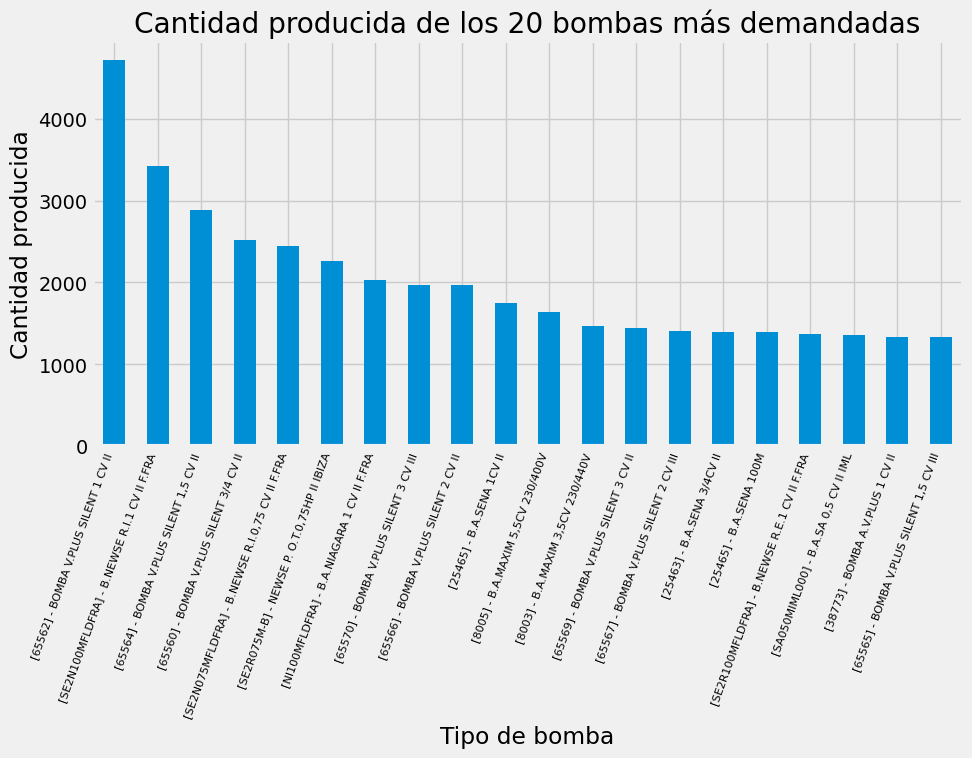

In [342]:
material_counts = df_bombs.groupby(['bomb_type', 'bomb_description'])['good_qty'].size().reset_index(name='count').sort_values(by='count', ascending=False)
material_counts['code_description'] = '[' + material_counts['bomb_type'].astype(str) + '] - ' + material_counts['bomb_description']
material_counts[0:20].plot(kind='bar', x='code_description', figsize=(10, 5))
plt.xlabel('Tipo de bomba')
plt.ylabel('Cantidad producida')
plt.title('Cantidad producida de los 20 bombas más demandadas')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(False)
plt.show()

>Gráfico 4: Cantidad producida de los 20 materiales menos demandados

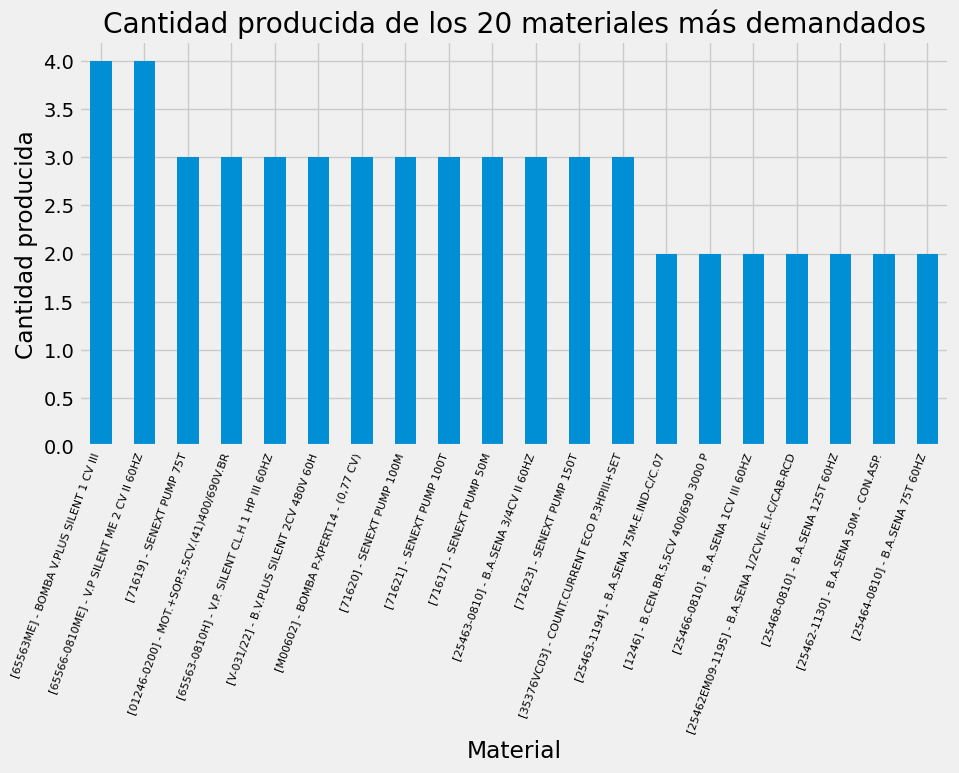

In [325]:
material_counts[-20:].plot(kind='bar', x='code_description', figsize=(10, 5))
plt.xlabel('Material')
plt.ylabel('Cantidad producida')
plt.title('Cantidad producida de los 20 materiales más demandados')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(False)
plt.show()

#### ¿Cuáles son los materiales más defectuosos?

Dada la cantidad de materiales, revisaremos los 20 más defectuosos y los 20 menos defectuosos
>Se revisa en la data que entre todos los registros, no hay ninguno que tenga QtyMalas_Total y CantidadMalas

#### ¿Cuáles son las máquinas que más y menos producen?

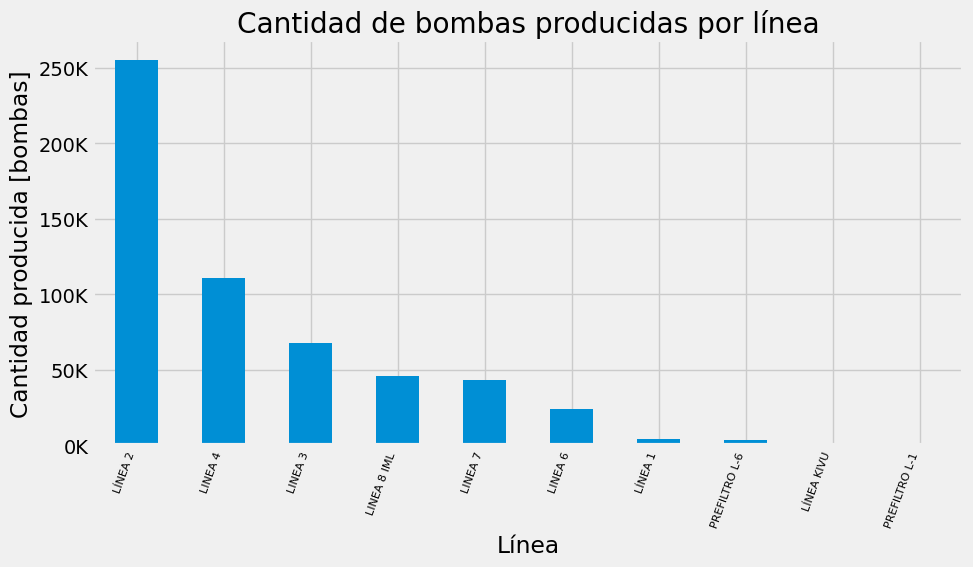

In [343]:
bomb_counts = df_bombs.groupby(['line'])['good_qty'].sum().reset_index(name='count').sort_values(by='count', ascending=False)
bomb_counts.plot(kind='bar', x='line', figsize=(10, 5))
plt.xlabel('Línea')
plt.ylabel('Cantidad producida [bombas]')
plt.title('Cantidad de bombas producidas por línea')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().yaxis.set_major_formatter(thousand_formatter)
plt.gca().legend().set_visible(False)
plt.show()

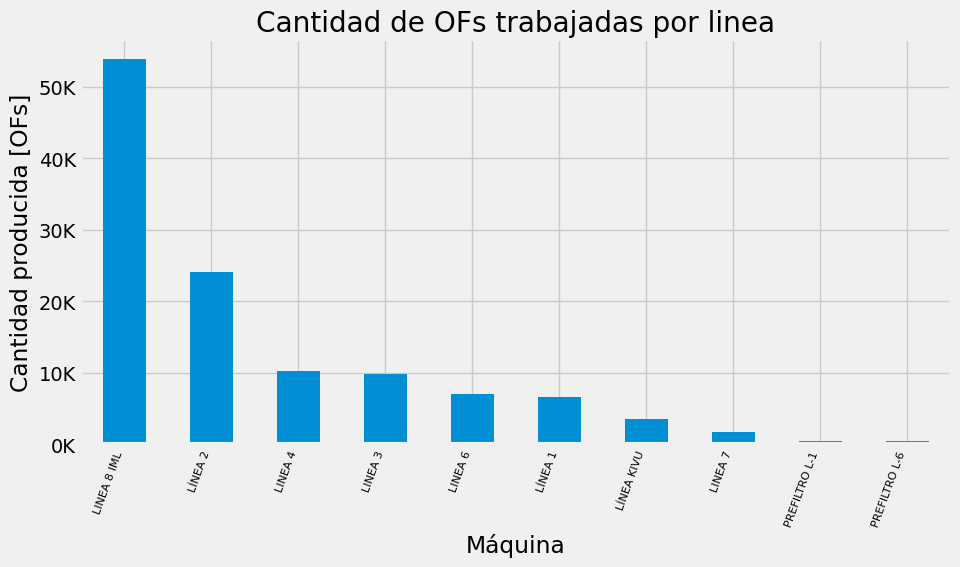

In [344]:
bomb_counts = df_bombs.groupby(['line'])['order'].size().reset_index(name='count').sort_values(by='count', ascending=False)
bomb_counts.plot(kind='bar', x='line', figsize=(10, 5))
plt.xlabel('Máquina')
plt.ylabel('Cantidad producida [OFs]')
plt.title('Cantidad de OFs trabajadas por linea')

plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().yaxis.set_major_formatter(thousand_formatter)
plt.gca().legend().set_visible(False)
plt.show()

#### ¿Cuáles son los tiempos de producción de las lineas?

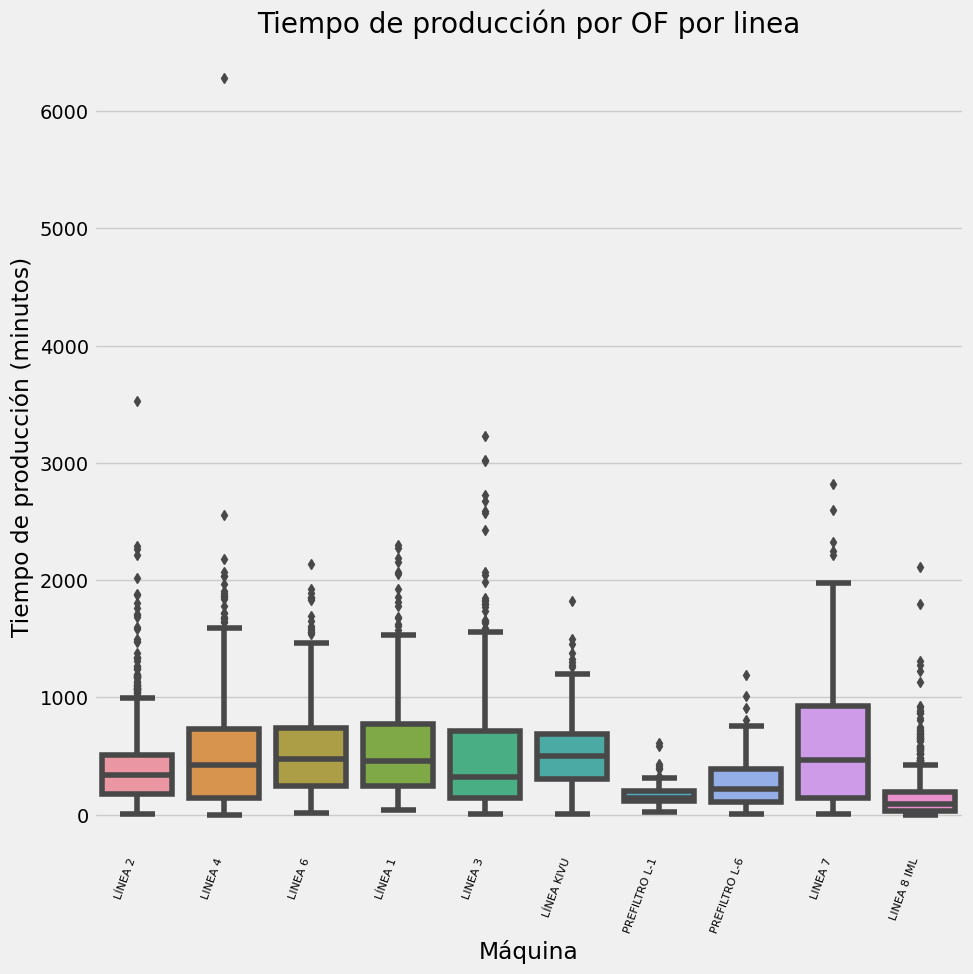

In [329]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_of, x='line', y='time_diff_minutes_calculated')
plt.xlabel('Máquina')
plt.ylabel('Tiempo de producción (minutos)')
plt.title('Tiempo de producción por OF por linea')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.show()

In [331]:
df_of[df_of.theorical_qty > 4000]

,order,bomb_type,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,theorical_time,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes,operators_distinct_ids,registers_qty,operators_distinct_qty,theorical_qty,theorical_qty_round,performance,performance_round
241,5175256,20578VP176/2,LINEA 7,3.0,3.0,0.0,3000.0,0.0,2020-01-25 06:02:25.730,2020-02-01 11:38:34.697,169110,1.1,169108.206,2818.4701,4599.75625,"[8733, 5030, 643, 5004, 654, 642]",43,6,4181.596591,4182.0,0.717429,0.71736


In [350]:
df_bombs[df_bombs.order == 5313435]

,order,bomb_type,bomb_description,line,plan_qty,total_good_qty,total_bad_qty,good_qty,bad_qty,start_date,end_date,theorical_diff,incidence_name,observations,theorical_time,operators_qty,operators_ids,operators_qty_calculated,time_diff_seconds_calculated,time_diff_minutes_calculated,total_operators_minutes
62131,5313435,M00603,"BOMBA P-XPERT16 - (1,03 CV)",LINEA 7,11.0,11.0,0.0,0.0,0.0,2022-06-01 11:11:42.270,2022-06-01 11:12:15.140,33,Produccion,NaN,2.95,2.0,"654,9317,",2,32.870,0.547833,1.095667
62132,5313435,M00603,"BOMBA P-XPERT16 - (1,03 CV)",LINEA 7,11.0,11.0,0.0,0.0,0.0,2022-06-01 11:12:15.140,2022-06-01 11:13:01.950,46,Produccion,NaN,2.95,2.0,"654,9317,",2,46.810,0.780167,1.560333
62133,5313435,M00603,"BOMBA P-XPERT16 - (1,03 CV)",LINEA 7,11.0,11.0,0.0,11.0,0.0,2022-06-01 11:13:01.950,2022-06-01 11:13:19.327,18,Produccion,NaN,2.95,2.0,"654,9317,",2,17.377,0.289617,0.579233


In [359]:
df_of[df_of.performance > 2].shape

(54, 22)

In [377]:
df_of[df_of.time_diff_minutes_calculated > 24*60].shape

(142, 22)

#### ¿Cuáles es la relación entre la cantidad teórica y la cantidad real?

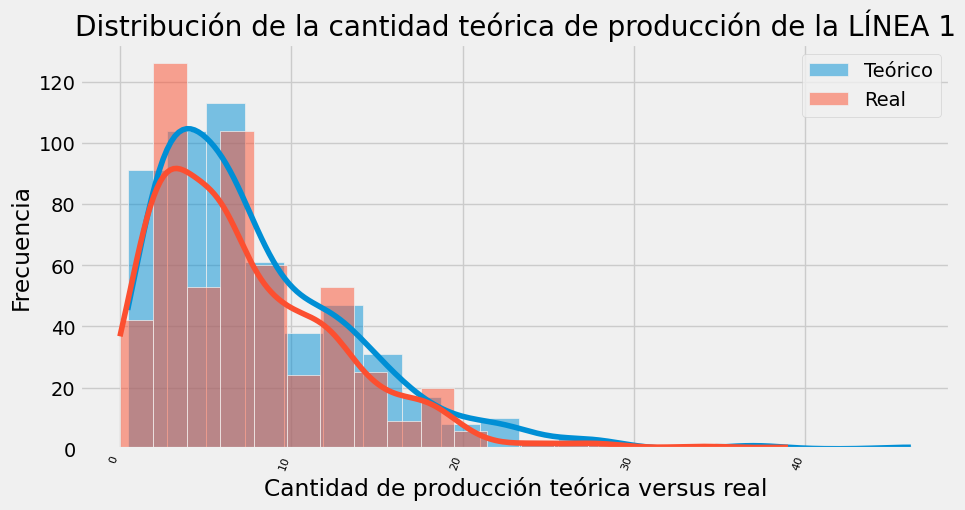

In [334]:
data = df_of[df_of.line == 'LÍNEA 1'].sort_values(by='theorical_qty')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='theorical_qty', bins=20, kde=True, label='Teórico')
sns.histplot(data=data, x='good_qty', bins=20, kde=True, label='Real')
plt.xlabel('Cantidad de producción teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LÍNEA 1')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

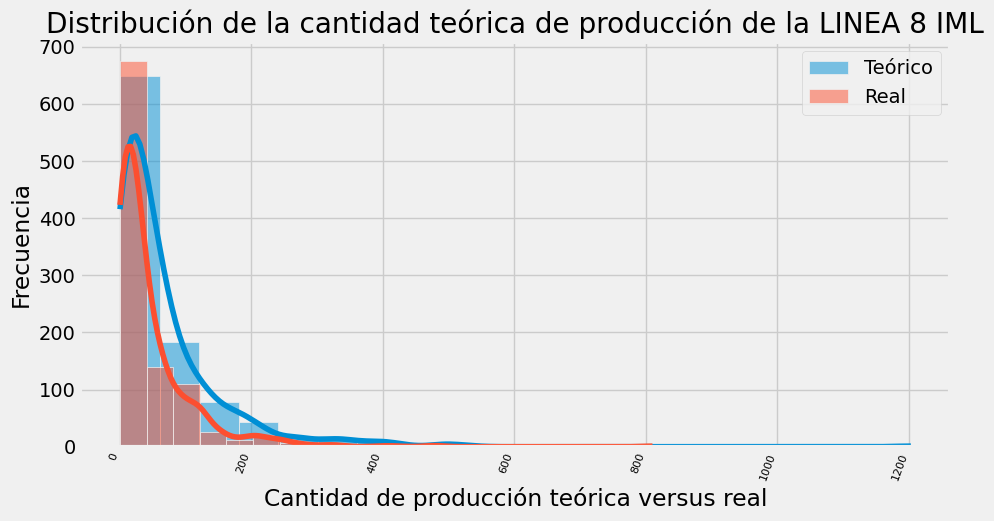

In [335]:
data = df_of[df_of.line == 'LINEA 8 IML'].sort_values(by='theorical_qty')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='theorical_qty', bins=20, kde=True, label='Teórico')
sns.histplot(data=data, x='good_qty', bins=20, kde=True, label='Real')
plt.xlabel('Cantidad de producción teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LINEA 8 IML')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

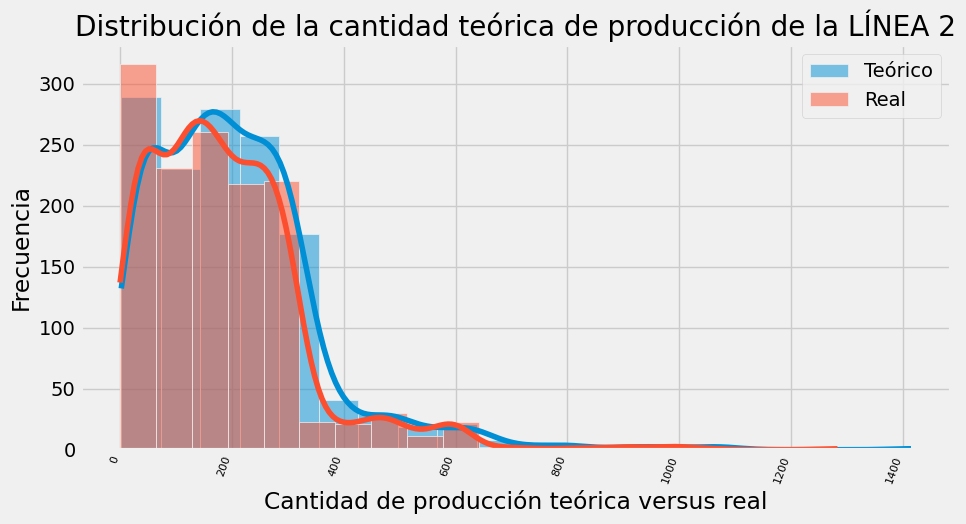

In [336]:
data = df_of[df_of.line == 'LÍNEA 2'].sort_values(by='theorical_qty')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='theorical_qty', bins=20, kde=True, label='Teórico')
sns.histplot(data=data, x='good_qty', bins=20, kde=True, label='Real')
plt.xlabel('Cantidad de producción teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LÍNEA 2')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.show()

#### Performance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


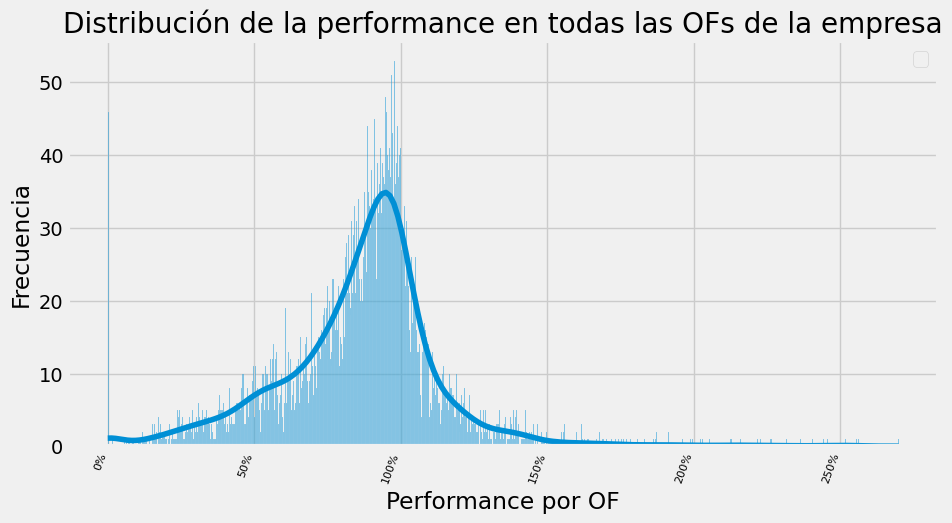

In [366]:
data = df_of.sort_values(by='performance')
data = df_of[df_of.performance < 3].sort_values(by='performance')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', bins=1000, kde=True)
plt.xlabel('Performance por OF')
plt.ylabel('Frecuencia')
plt.title('Distribución de la performance en todas las OFs de la empresa')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


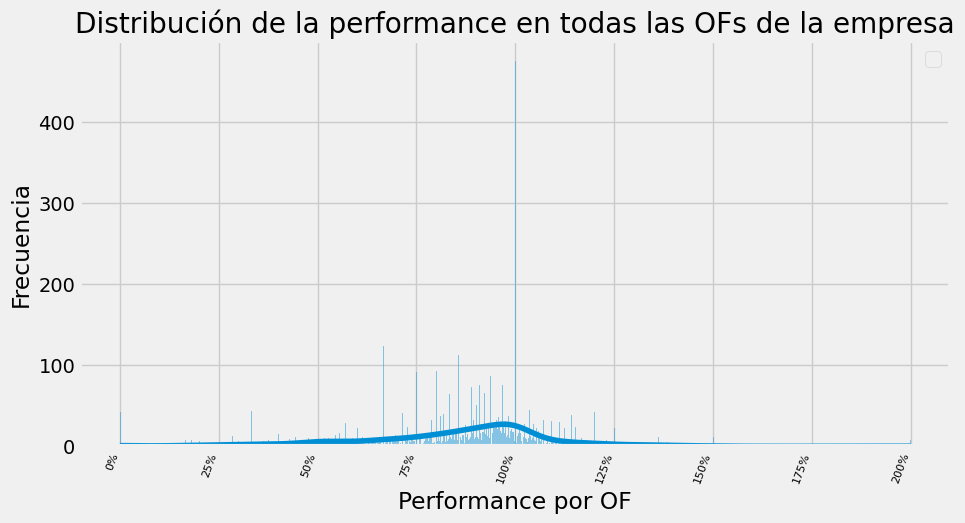

In [373]:
data = df_of.sort_values(by='performance')
data = df_of[(df_of.performance < 1.5)].sort_values(by='performance')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance_round', bins=1000, kde=True)
plt.xlabel('Performance por OF')
plt.ylabel('Frecuencia')
plt.title('Distribución de la performance en todas las OFs de la empresa')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


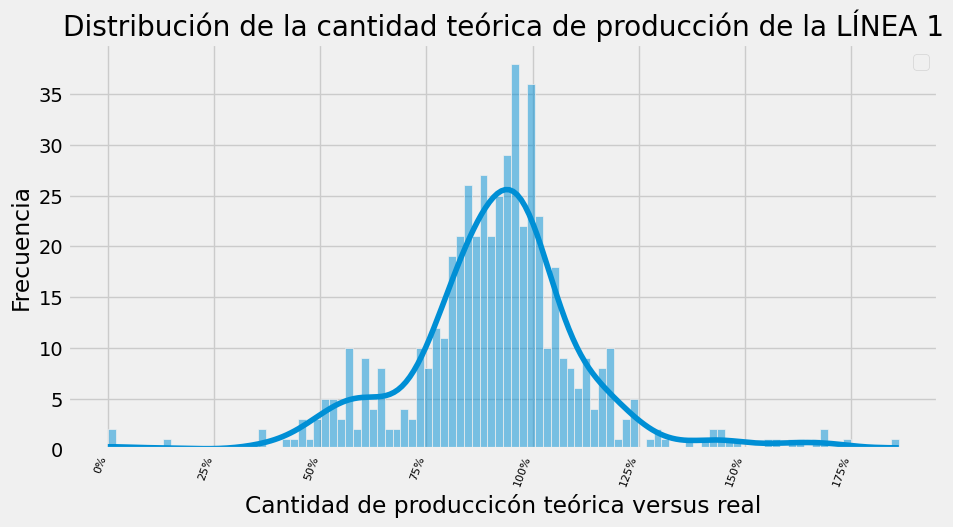

In [364]:
data = df_of[df_of.line == 'LÍNEA 1'].sort_values(by='performance')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', bins=100, kde=True)
plt.xlabel('Cantidad de produccicón teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LÍNEA 1')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


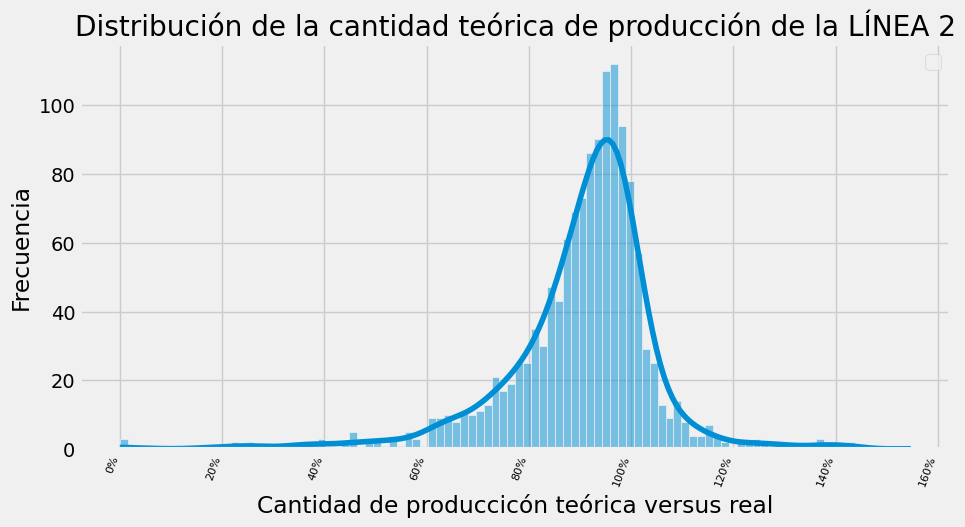

In [339]:
data = df_of[df_of.line == 'LÍNEA 2'].sort_values(by='performance')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='performance', bins=100, kde=True)
plt.xlabel('Cantidad de produccicón teórica versus real')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad teórica de producción de la LÍNEA 2')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(True)
plt.gca().xaxis.set_major_formatter(percentage_formatter)
plt.show()